# Omdena  - Milan Chapter Agrifoods
## AI for Sustainable agri-food systems: use of Satellite Imagery
### Exploratory analysis of fresh vegetables crop production in Italy 2020-2022
#### Author: Maria Fisher 


Here we have analysed the major areas and crop produced in Italy. 
Crop dataset used in this study was downloaded from the Italian National Institute of Statistics (Istat).
The objective is to get some insights about crop production and its respective areas in Italy and how climate change have affected crop production in the last 3 years. 


In [1]:
import warnings 
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import seaborn as sns 
import scipy 
import sklearn
import geopandas as gpd
import pgeocode
import folium
import sys
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

In [2]:
fresh_veg = pd.read_csv('./Italy_crop_data/italy_fresh_veg.csv',skipinitialspace=True)
fresh_veg.head()

,ITTER107,Territory,TIPO_DATO5,Data type,AGRI_MADRE,Type of crop,TIME,Select time,Value,Flag Codes,Flags
0,ITC16,Cuneo,TP_QUIN_EXT,total production - quintals,RADIINGRE,chicory and radicchio in greenhouses,2020,2020,850,NaN,NaN
1,ITC16,Cuneo,HP_Q_EXT,harvested production - quintals,RADIINGRE,chicory and radicchio in greenhouses,2020,2020,850,NaN,NaN
2,ITC16,Cuneo,ART_ARE,total area - ares,RADIINGRE,chicory and radicchio in greenhouses,2020,2020,360,NaN,NaN
3,ITC17,Asti,TP_QUIN_EXT,total production - quintals,RADIINGRE,chicory and radicchio in greenhouses,2020,2020,870,NaN,NaN
4,ITC17,Asti,HP_Q_EXT,harvested production - quintals,RADIINGRE,chicory and radicchio in greenhouses,2020,2020,870,NaN,NaN


## Pre-processing dataset 

In [3]:
# Drop Columns
fresh_veg = fresh_veg.drop(columns =['ITTER107','TIPO_DATO5','AGRI_MADRE', 'TIME', 'Flag Codes','Flags' ])
fresh_veg

,Territory,Data type,Type of crop,Select time,Value
0,Cuneo,total production - quintals,chicory and radicchio in greenhouses,2020,850
1,Cuneo,harvested production - quintals,chicory and radicchio in greenhouses,2020,850
2,Cuneo,total area - ares,chicory and radicchio in greenhouses,2020,360
3,Asti,total production - quintals,chicory and radicchio in greenhouses,2020,870
4,Asti,harvested production - quintals,chicory and radicchio in greenhouses,2020,870
...,...,...,...,...,...
25228,Rimini,harvested production - quintals,other fresh legumes,2022,1360
25229,Perugia,total area - hectares,other fresh legumes,2022,5
25230,Perugia,total production - quintals,other fresh legumes,2022,400
25231,Perugia,harvested production - quintals,other fresh legumes,2022,400


In [4]:
# Rename Columns
fresh_veg = fresh_veg.rename(columns = {'Select time':'Year', 'Type of crop':'Type_crop', 'Data type':'Data_type', 'Territory':'City'})


In [5]:
def show_info(fresh_veg):
    print('DATASET SHAPE: ', fresh_veg.shape, '\n')
    print('-'*50)
    print('FEATURE DATA TYPES:')
    print(fresh_veg.info())
    print('\n', '-'*50)
    print('NUMBER OF UNIQUE VALUES PER FEATURE:', '\n')
    print(fresh_veg.nunique())
    print('\n', '-'*50)
    print('NULL VALUES PER FEATURE')
    print(fresh_veg.isnull().sum())
show_info(fresh_veg)

DATASET SHAPE:  (25233, 5) 

--------------------------------------------------
FEATURE DATA TYPES:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25233 entries, 0 to 25232
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   City       25233 non-null  object
 1   Data_type  25233 non-null  object
 2   Type_crop  25233 non-null  object
 3   Year       25233 non-null  int64 
 4   Value      25233 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 985.8+ KB
None

 --------------------------------------------------
NUMBER OF UNIQUE VALUES PER FEATURE: 

City          105
Data_type       5
Type_crop      64
Year            3
Value        3903
dtype: int64

 --------------------------------------------------
NULL VALUES PER FEATURE
City         0
Data_type    0
Type_crop    0
Year         0
Value        0
dtype: int64


## Cities in Italy producing fresh vegetables

In [6]:
#fresh_veg.City.unique()


In [7]:
fresh_veg.Data_type.unique()

array(['total production - quintals ', 'harvested production - quintals ',
       'total area - ares', 'total area - hectares',
       'production area - hectares '], dtype=object)

## Select only values for total fresh vegetables production - quintals


In [8]:
fresh_veg_prod = fresh_veg[fresh_veg['Data_type'] == 'total production - quintals ']
fresh_veg_prod.head()

,City,Data_type,Type_crop,Year,Value
0,Cuneo,total production - quintals,chicory and radicchio in greenhouses,2020,850
3,Asti,total production - quintals,chicory and radicchio in greenhouses,2020,870
6,La Spezia,total production - quintals,chicory and radicchio in greenhouses,2020,600
7,La Spezia,total production - quintals,chicory and radicchio in greenhouses,2021,600
12,Varese,total production - quintals,chicory and radicchio in greenhouses,2020,30


In [9]:
fresh_veg_prod = fresh_veg_prod.rename(columns = {'Value':'Total_production'})
fresh_veg_prod

,City,Data_type,Type_crop,Year,Total_production
0,Cuneo,total production - quintals,chicory and radicchio in greenhouses,2020,850
3,Asti,total production - quintals,chicory and radicchio in greenhouses,2020,870
6,La Spezia,total production - quintals,chicory and radicchio in greenhouses,2020,600
7,La Spezia,total production - quintals,chicory and radicchio in greenhouses,2021,600
12,Varese,total production - quintals,chicory and radicchio in greenhouses,2020,30
...,...,...,...,...,...
25211,Salerno,total production - quintals,tomato for process in greenhouse,2021,25000
25214,Lecce,total production - quintals,tomato for process in greenhouse,2021,22000
25224,Imperia,total production - quintals,other fresh legumes,2022,70
25227,Rimini,total production - quintals,other fresh legumes,2022,1360


In [10]:
fresh_veg_prod = fresh_veg_prod.drop(columns =['Data_type'])
fresh_veg_prod

,City,Type_crop,Year,Total_production
0,Cuneo,chicory and radicchio in greenhouses,2020,850
3,Asti,chicory and radicchio in greenhouses,2020,870
6,La Spezia,chicory and radicchio in greenhouses,2020,600
7,La Spezia,chicory and radicchio in greenhouses,2021,600
12,Varese,chicory and radicchio in greenhouses,2020,30
...,...,...,...,...
25211,Salerno,tomato for process in greenhouse,2021,25000
25214,Lecce,tomato for process in greenhouse,2021,22000
25224,Imperia,other fresh legumes,2022,70
25227,Rimini,other fresh legumes,2022,1360


## Fresh vegetables production in 2020-2022

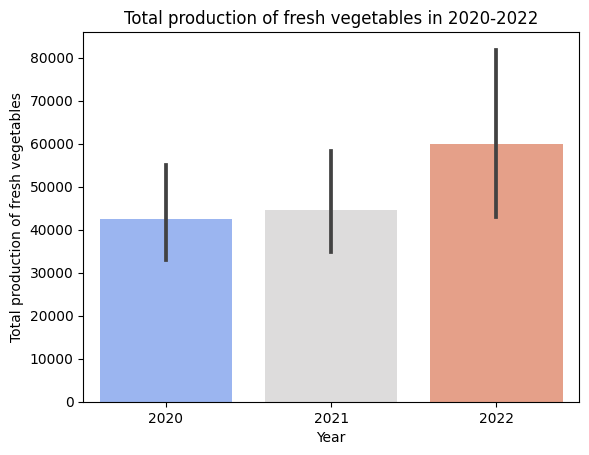

In [11]:

sns.barplot(x= 'Year', y= 'Total_production',data = fresh_veg_prod, palette='coolwarm')
plt.title('Total production of fresh vegetables in 2020-2022')
plt.xlabel('Year')
plt.ylabel('Total production of fresh vegetables')
plt.show()



## Fresh vegetables production by Cities 

In [12]:
fresh_veg_prod_region = fresh_veg_prod.groupby(by = fresh_veg_prod.City)['Total_production','City'].sum().reset_index().sort_values(by = 'Total_production', ascending = False)
fresh_veg_prod_region



,City,Total_production
32,Foggia,56993500
67,Piacenza,23479479
30,Ferrara,23074507
42,Latina,20229419
81,Salerno,16043370
...,...,...
12,Biella,9650
96,Valle d'Aosta / Vallée d'Aoste,6872
23,Como,5700
99,Verbano-Cusio-Ossola,4280


In [13]:
region = fresh_veg_prod_region.nlargest(30, 'Total_production')

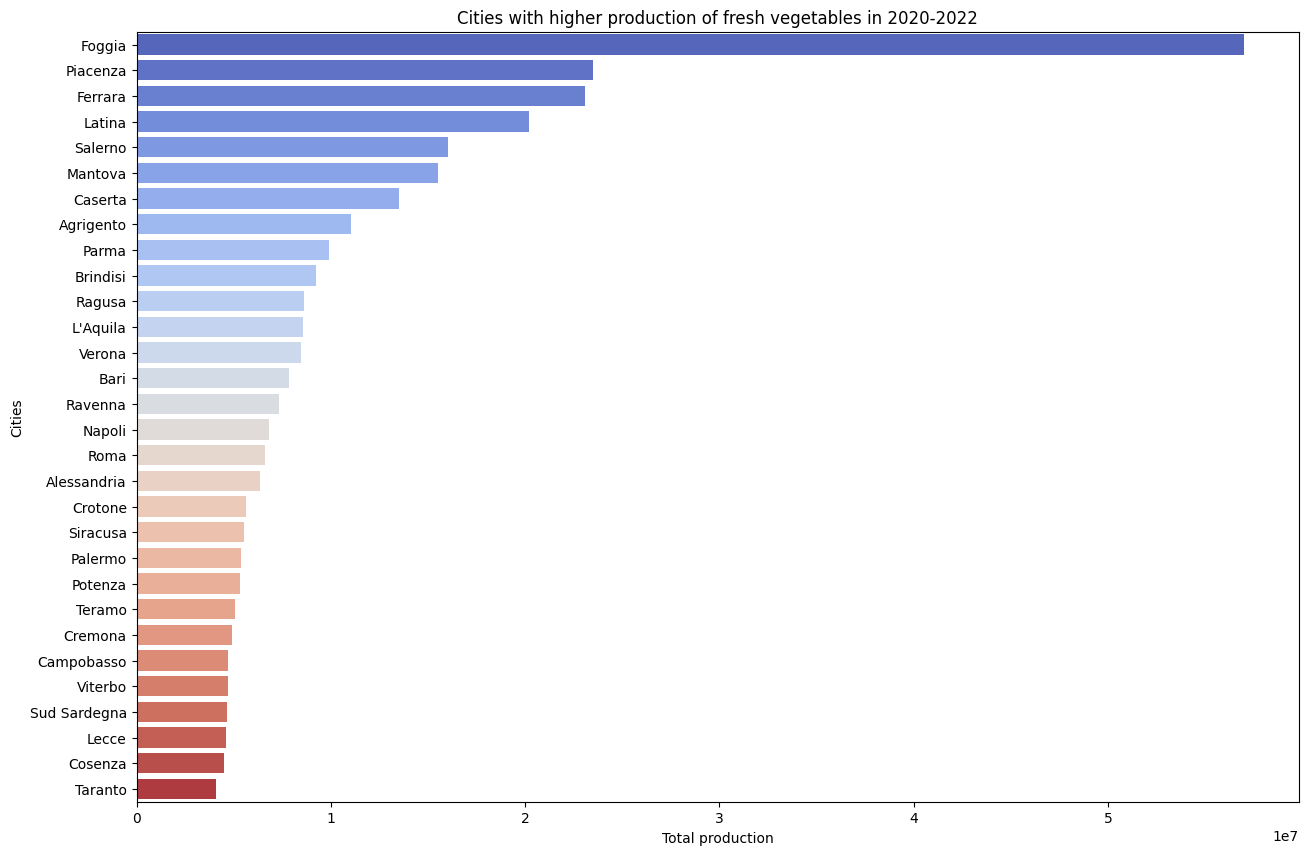

In [14]:
plt.figure(figsize= (15, 10))
sns.barplot(x= region['Total_production'],y= region['City'], orient='h', palette='coolwarm');
plt.title('Cities with higher production of fresh vegetables in 2020-2022')
plt.xlabel('Total production')
plt.ylabel('Cities')
plt.show() 

## Fresh vegetables  2020-2022

In [15]:
print(fresh_veg_prod.Type_crop.max())
print(fresh_veg_prod.Type_crop.value_counts())
print(fresh_veg_prod.Type_crop.nunique())



white cabbage
courgette in open field                                        305
fresh beans in open field                                      284
lettuce in open field                                          276
onions in open field                                           272
cauliflower and broccoli in open field                         260
                                                              ... 
shallots in open field                                          20
gherkins in open field                                          10
other leafy or stalked vegetables n.e.c. (excluding chards)      6
other fresh vegetables n.e.c. (excluding broad beans)            5
tomato for process in greenhouse                                 3
Name: Type_crop, Length: 64, dtype: int64
64


Dataset shows there are 64 different types of industrial crop cultivated in Italy. The top most produced crops are :
Courgette in open field, Fresh beans in open field, Lettuce in open field, Onions in open field, Cauliflower and Broccoli in open field. 


In [16]:
fresh_veg_prod.describe()

,Year,Total_production
count,8321.000000,8.321000e+03
mean,2020.825742,4.701730e+04
std,0.756171,3.557369e+05
min,2020.000000,0.000000e+00
25%,2020.000000,5.850000e+02
50%,2021.000000,2.910000e+03
75%,2021.000000,1.746500e+04
max,2022.000000,1.425000e+07


<AxesSubplot: >

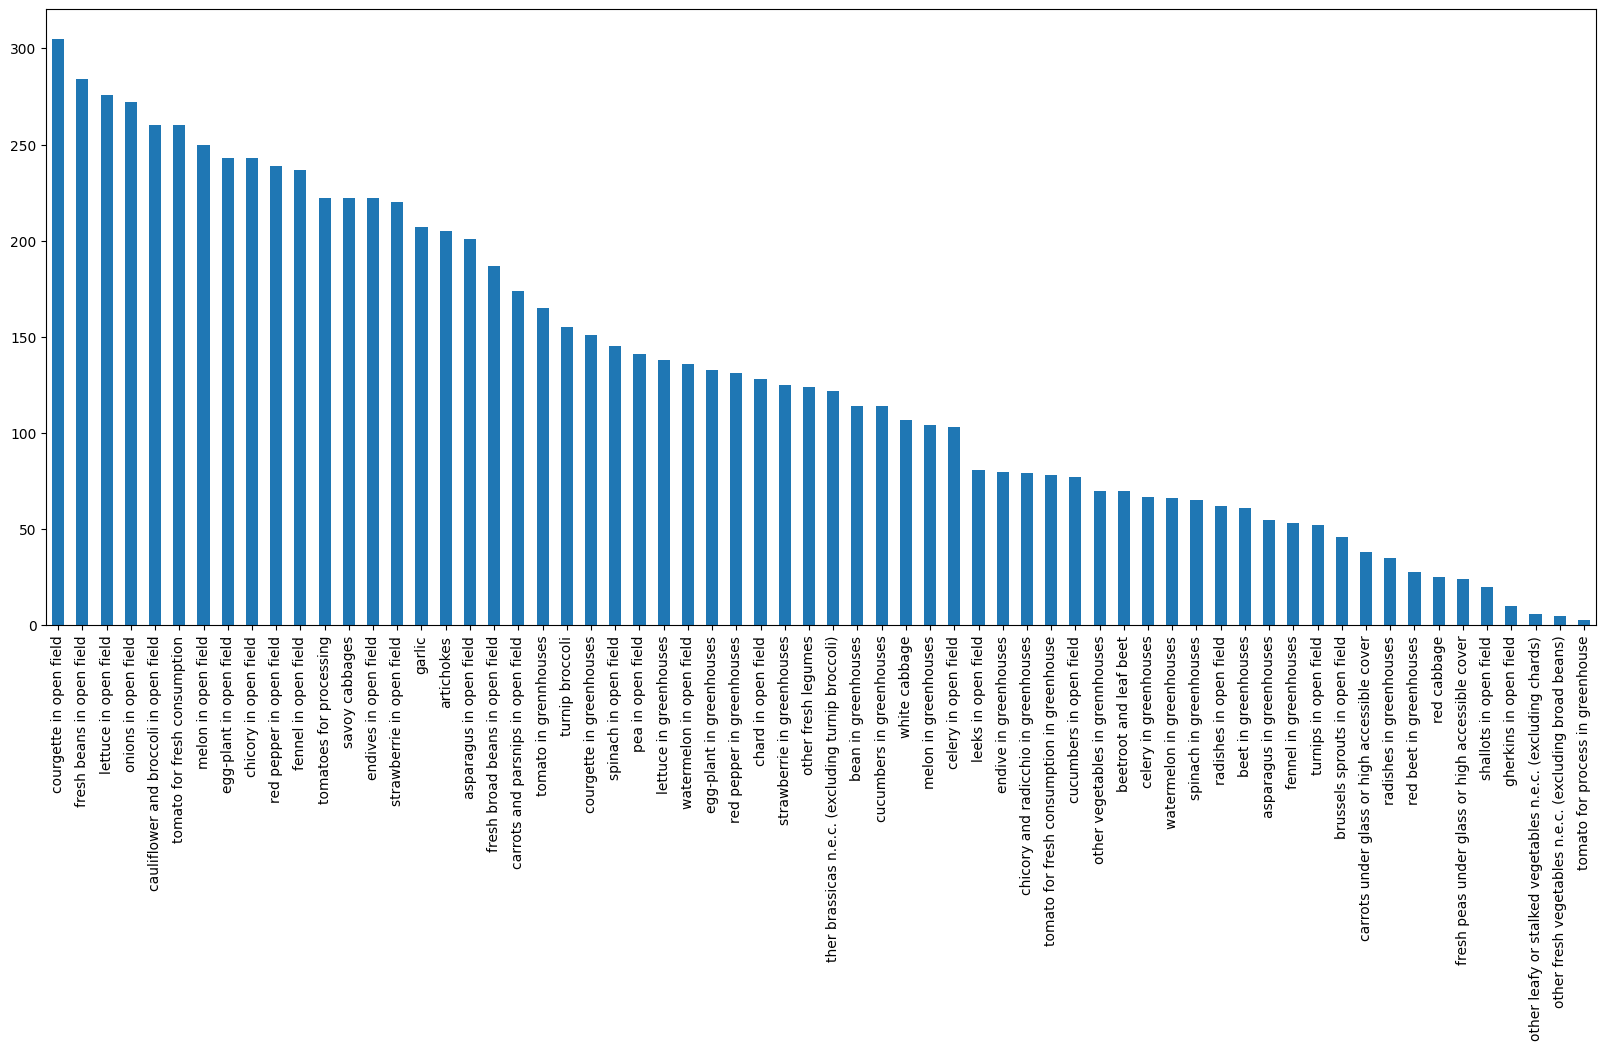

In [17]:
plt.figure(figsize=(20,8))
fresh_veg_prod ['Type_crop'].value_counts().plot.bar()

## Subseting data

In [18]:
fresh_veg_top10 = fresh_veg_prod.apply(lambda row: row[fresh_veg_prod['Type_crop'].isin(['courgette in open field', 'fresh beans in open field',
                                                                                         'lettuce in open field','onions in open field',
                                                                                         'cauliflower and Broccoli in open field',
                                                                                        'tomato for fresh consumption','melon in open field',
                                                                                         'egg-plant in open field','chicory in open field','red pepper in open field'])])

fresh_veg_top10.head()

,City,Type_crop,Year,Total_production
2201,Torino,melon in open field,2020,1050
2202,Torino,melon in open field,2021,1320
2203,Torino,melon in open field,2022,800
2209,Biella,melon in open field,2020,80
2210,Biella,melon in open field,2021,0


## Stats

In [19]:
fresh_veg_top10.describe().astype(int)

,Year,Total_production
count,2372,2372
mean,2020,38156
std,0,90989
min,2020,0
25%,2020,1590
50%,2021,7317
75%,2022,35000
max,2022,1185600


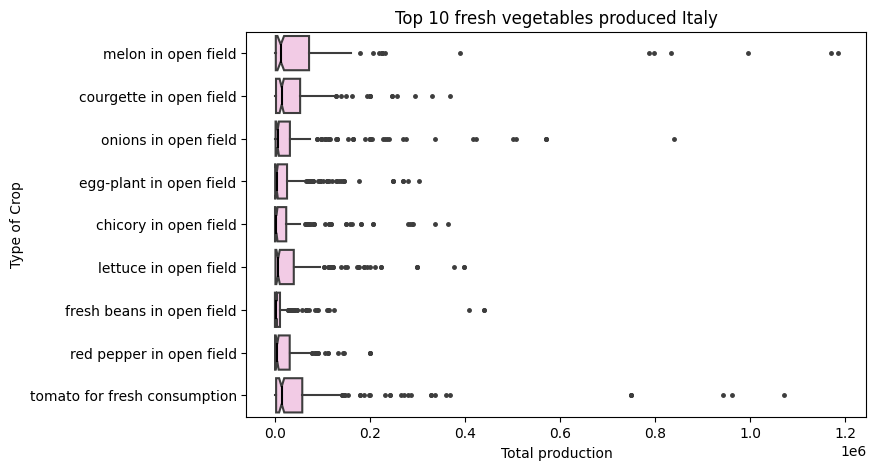

In [20]:
plt.figure(figsize=(8,5))

sns.boxplot(
    data=fresh_veg_top10, y="Type_crop", x="Total_production",
    notch=True, showcaps=False,
    flierprops={"marker": "."},
    boxprops={"facecolor": (.9, .6, .8, .5)},
    medianprops={"color": "black"},
)
plt.title('Top 10 fresh vegetables produced Italy')
plt.ylabel('Type of Crop')
plt.xlabel('Total production')
plt.show()

## Vizualization of ten type of fresh vegetables produced in Italy in the period of 2020-2022 

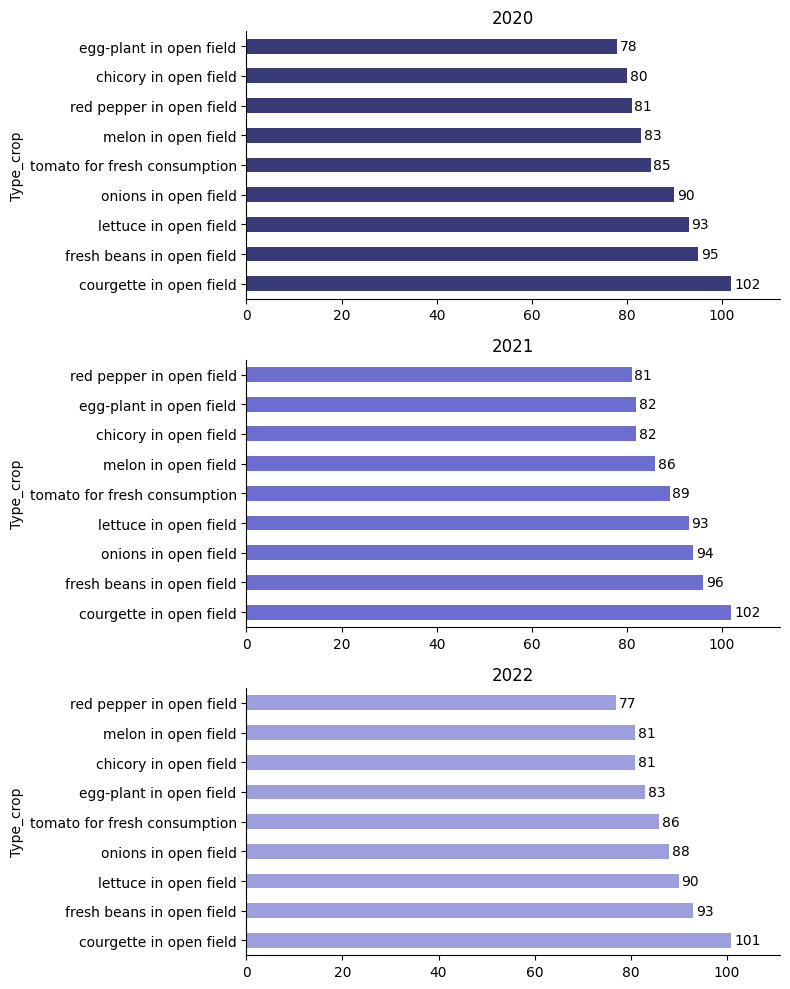

In [21]:
fig, axs = plt.subplots(3, figsize=(8, 10))

plot1 = fresh_veg_top10[fresh_veg_top10.Year == 2020].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#393b79', title='2020', ax=axs[0])
plot2 = fresh_veg_top10[fresh_veg_top10.Year == 2021].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2021', ax=axs[1])
plot3 = fresh_veg_top10[fresh_veg_top10.Year == 2022].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#9c9ede', title='2022', ax=axs[2])

for ax in axs.flat:
    ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge', padding=2)
    ax.margins(x=0.1)
sns.despine()
plt.tight_layout()
plt.show()

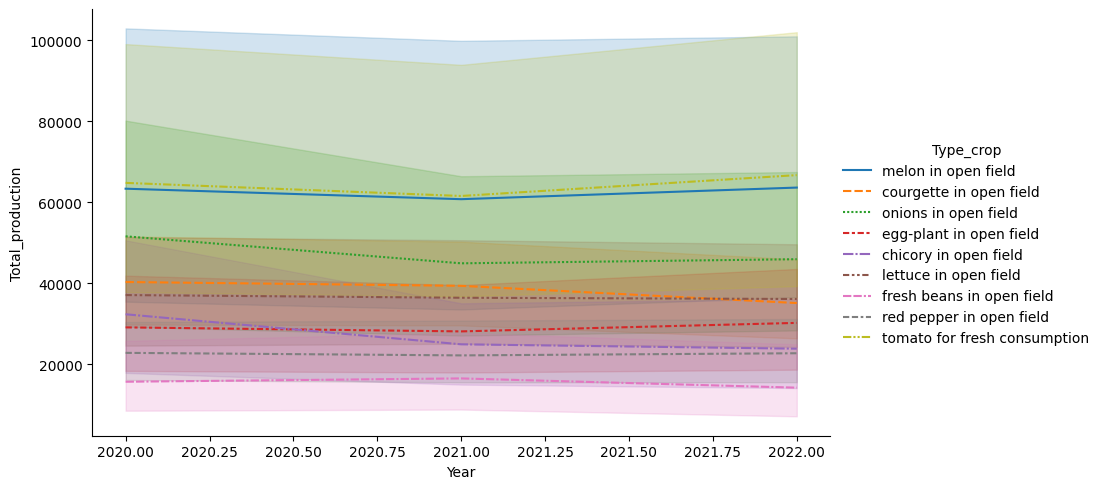

In [22]:
#Crop harvested by year
plotcrop10 = sns.relplot(kind='line', data=fresh_veg_top10, x='Year', y='Total_production', hue='Type_crop', style='Type_crop', aspect=1.75)


In [23]:
# Select year 2020 for future join with fertilizer
fresh_veg2020 = fresh_veg_top10[fresh_veg_top10['Year'] == 2020]
fresh_veg2020



,City,Type_crop,Year,Total_production
2201,Torino,melon in open field,2020,1050
2209,Biella,melon in open field,2020,80
2222,Cuneo,melon in open field,2020,1540
2231,Asti,melon in open field,2020,1000
2240,Alessandria,melon in open field,2020,12750
...,...,...,...,...
23667,Cosenza,tomato for fresh consumption,2020,188105
23688,Trapani,tomato for fresh consumption,2020,33000
23704,Taranto,tomato for fresh consumption,2020,20000
23713,Ragusa,tomato for fresh consumption,2020,180000


### Create columns for each type crop 2020

In [24]:
# Create columns for each type crop
fresh_veg2020_pivot = fresh_veg2020.pivot_table(index=['City', 'Year'],aggfunc='sum', columns='Type_crop',values=['Total_production'])
fresh_veg2020_pivot

Total_production                          \
Type_crop          chicory in open field courgette in open field   
City          Year                                                 
Agrigento     2020                   NaN                 39600.0   
Alessandria   2020                7200.0                 30060.0   
Ancona        2020                1807.0                  3714.0   
Arezzo        2020                4800.0                 13050.0   
Ascoli Piceno 2020               24743.0                  8186.0   
...                                  ...                     ...   
Vercelli      2020                   NaN                 54000.0   
Verona        2020              290750.0                247310.0   
Vibo Valentia 2020                   NaN                 83635.0   
Vicenza       2020               32750.0                 27880.0   
Viterbo       2020                   NaN                 14220.0   

                                                                      \
Type_crop          egg-plant in open field fresh beans in open field   
City          Year                                                     
Agrigento     2020                 79950.0                    4160.0   
Alessandria   2020                  3640.0                    6160.0   
Ancona        2020                  1655.0                   16015.0   
Arezzo        2020                   560.0                     560.0   
Ascoli Piceno 2020                  4362.0                    4670.0   
...                                    ...                       ...   
Vercelli      2020                   440.0                    3225.0   
Verona        2020                 47410.0                   40400.0   
Vibo Valentia 2020                 13500.0                   18000.0   
Vicenza       2020                   480.0                    2725.0   
Viterbo       2020                  1590.0                    5540.0   

                                                              \
Type_crop          lettuce in open field melon in open field   
City          Year                                             
Agrigento     2020              104500.0           1185600.0   
Alessandria   2020               10320.0             12750.0   
Ancona        2020                3197.0              3117.0   
Arezzo        2020                 660.0              9920.0   
Ascoli Piceno 2020               37435.0              8074.0   
...                                  ...                 ...   
Vercelli      2020                 150.0                 NaN   
Verona        2020               20060.0             79640.0   
Vibo Valentia 2020               11520.0                 NaN   
Vicenza       2020                1050.0               315.0   
Viterbo       2020                 320.0             82000.0   

                                                                  \
Type_crop          onions in open field red pepper in open field   
City          Year                                                 
Agrigento     2020             129850.0                  53940.0   
Alessandria   2020             275550.0                   3920.0   
Ancona        2020               1474.0                   2368.0   
Arezzo        2020               6000.0                   7800.0   
Ascoli Piceno 2020               2342.0                   6823.0   
...                                 ...                      ...   
Vercelli      2020                  NaN                      NaN   
Verona        2020             237235.0                   3920.0   
Vibo Valentia 2020             164400.0                  57170.0   
Vicenza       2020              49600.0                    830.0   
Viterbo       2020               2880.0                   5600.0   

                                                 
Type_crop          tomato for fresh consumption  
City          Year                               
Agrigento     2020                     943000.0  
Alessandria 

In [25]:
# Drop level
fresh_veg2020_pivot.columns = fresh_veg2020_pivot.columns.droplevel()
fresh_veg2020_pivot

,Type_crop,chicory in open field,courgette in open field,egg-plant in open field,fresh beans in open field,lettuce in open field,melon in open field,onions in open field,red pepper in open field,tomato for fresh consumption
City,Year,,,,,,,,,
Agrigento,2020,NaN,39600.0,79950.0,4160.0,104500.0,1185600.0,129850.0,53940.0,943000.0
Alessandria,2020,7200.0,30060.0,3640.0,6160.0,10320.0,12750.0,275550.0,3920.0,36750.0
Ancona,2020,1807.0,3714.0,1655.0,16015.0,3197.0,3117.0,1474.0,2368.0,13594.0
Arezzo,2020,4800.0,13050.0,560.0,560.0,660.0,9920.0,6000.0,7800.0,8500.0
Ascoli Piceno,2020,24743.0,8186.0,4362.0,4670.0,37435.0,8074.0,2342.0,6823.0,38759.0
...,...,...,...,...,...,...,...,...,...,...
Vercelli,2020,NaN,54000.0,440.0,3225.0,150.0,NaN,NaN,NaN,660.0
Verona,2020,290750.0,247310.0,47410.0,40400.0,20060.0,79640.0,237235.0,3920.0,4590.0
Vibo Valentia,2020,NaN,83635.0,13500.0,18000.0,11520.0,NaN,164400.0,57170.0,58240.0


In [26]:
fresh_veg2020_pivot = fresh_veg2020_pivot.fillna(0)
fresh_veg2020_pivot

,Type_crop,chicory in open field,courgette in open field,egg-plant in open field,fresh beans in open field,lettuce in open field,melon in open field,onions in open field,red pepper in open field,tomato for fresh consumption
City,Year,,,,,,,,,
Agrigento,2020,0.0,39600.0,79950.0,4160.0,104500.0,1185600.0,129850.0,53940.0,943000.0
Alessandria,2020,7200.0,30060.0,3640.0,6160.0,10320.0,12750.0,275550.0,3920.0,36750.0
Ancona,2020,1807.0,3714.0,1655.0,16015.0,3197.0,3117.0,1474.0,2368.0,13594.0
Arezzo,2020,4800.0,13050.0,560.0,560.0,660.0,9920.0,6000.0,7800.0,8500.0
Ascoli Piceno,2020,24743.0,8186.0,4362.0,4670.0,37435.0,8074.0,2342.0,6823.0,38759.0
...,...,...,...,...,...,...,...,...,...,...
Vercelli,2020,0.0,54000.0,440.0,3225.0,150.0,0.0,0.0,0.0,660.0
Verona,2020,290750.0,247310.0,47410.0,40400.0,20060.0,79640.0,237235.0,3920.0,4590.0
Vibo Valentia,2020,0.0,83635.0,13500.0,18000.0,11520.0,0.0,164400.0,57170.0,58240.0


In [27]:
#Rename index
fresh_veg2020_pivot = fresh_veg2020_pivot.rename_axis(None,axis=1)
fresh_veg2020_pivot

,,chicory in open field,courgette in open field,egg-plant in open field,fresh beans in open field,lettuce in open field,melon in open field,onions in open field,red pepper in open field,tomato for fresh consumption
City,Year,,,,,,,,,
Agrigento,2020,0.0,39600.0,79950.0,4160.0,104500.0,1185600.0,129850.0,53940.0,943000.0
Alessandria,2020,7200.0,30060.0,3640.0,6160.0,10320.0,12750.0,275550.0,3920.0,36750.0
Ancona,2020,1807.0,3714.0,1655.0,16015.0,3197.0,3117.0,1474.0,2368.0,13594.0
Arezzo,2020,4800.0,13050.0,560.0,560.0,660.0,9920.0,6000.0,7800.0,8500.0
Ascoli Piceno,2020,24743.0,8186.0,4362.0,4670.0,37435.0,8074.0,2342.0,6823.0,38759.0
...,...,...,...,...,...,...,...,...,...,...
Vercelli,2020,0.0,54000.0,440.0,3225.0,150.0,0.0,0.0,0.0,660.0
Verona,2020,290750.0,247310.0,47410.0,40400.0,20060.0,79640.0,237235.0,3920.0,4590.0
Vibo Valentia,2020,0.0,83635.0,13500.0,18000.0,11520.0,0.0,164400.0,57170.0,58240.0


In [28]:
# Reset index
fresh_veg2020_pivot = fresh_veg2020_pivot.reset_index()
fresh_veg2020_pivot

,City,Year,chicory in open field,courgette in open field,egg-plant in open field,fresh beans in open field,lettuce in open field,melon in open field,onions in open field,red pepper in open field,tomato for fresh consumption
0,Agrigento,2020,0.0,39600.0,79950.0,4160.0,104500.0,1185600.0,129850.0,53940.0,943000.0
1,Alessandria,2020,7200.0,30060.0,3640.0,6160.0,10320.0,12750.0,275550.0,3920.0,36750.0
2,Ancona,2020,1807.0,3714.0,1655.0,16015.0,3197.0,3117.0,1474.0,2368.0,13594.0
3,Arezzo,2020,4800.0,13050.0,560.0,560.0,660.0,9920.0,6000.0,7800.0,8500.0
4,Ascoli Piceno,2020,24743.0,8186.0,4362.0,4670.0,37435.0,8074.0,2342.0,6823.0,38759.0
...,...,...,...,...,...,...,...,...,...,...,...
98,Vercelli,2020,0.0,54000.0,440.0,3225.0,150.0,0.0,0.0,0.0,660.0
99,Verona,2020,290750.0,247310.0,47410.0,40400.0,20060.0,79640.0,237235.0,3920.0,4590.0
100,Vibo Valentia,2020,0.0,83635.0,13500.0,18000.0,11520.0,0.0,164400.0,57170.0,58240.0
101,Vicenza,2020,32750.0,27880.0,480.0,2725.0,1050.0,315.0,49600.0,830.0,0.0


### Create columns for each type crop 2021

In [29]:
# Select year 2020 for future join with fertilizer
fresh_veg2021 = fresh_veg_top10[fresh_veg_top10['Year'] == 2021]
fresh_veg2021



,City,Type_crop,Year,Total_production
2202,Torino,melon in open field,2021,1320
2210,Biella,melon in open field,2021,0
2214,Verbano-Cusio-Ossola,melon in open field,2021,200
2217,Novara,melon in open field,2021,250
2223,Cuneo,melon in open field,2021,1260
...,...,...,...,...
23668,Cosenza,tomato for fresh consumption,2021,199320
23689,Trapani,tomato for fresh consumption,2021,33000
23705,Taranto,tomato for fresh consumption,2021,20000
23714,Ragusa,tomato for fresh consumption,2021,180000


### Create columns for each type crop 

In [30]:
# Create columns for each type crop
fresh_veg2021_pivot = fresh_veg2021.pivot_table(index=['City', 'Year'],aggfunc='sum', columns='Type_crop',values=['Total_production'])
fresh_veg2021_pivot

Total_production                          \
Type_crop          chicory in open field courgette in open field   
City          Year                                                 
Agrigento     2021                   NaN                 39000.0   
Alessandria   2021                5520.0                 72900.0   
Ancona        2021                1807.0                  3714.0   
Arezzo        2021                3200.0                 12180.0   
Ascoli Piceno 2021               24743.0                  8186.0   
...                                  ...                     ...   
Vercelli      2021                 160.0                 60800.0   
Verona        2021              181200.0                256990.0   
Vibo Valentia 2021                   NaN                 83635.0   
Vicenza       2021               25550.0                 14670.0   
Viterbo       2021                   NaN                 14200.0   

                                                                      \
Type_crop          egg-plant in open field fresh beans in open field   
City          Year                                                     
Agrigento     2021                 78155.0                    4266.0   
Alessandria   2021                  3080.0                    6160.0   
Ancona        2021                  1655.0                   16015.0   
Arezzo        2021                   560.0                    3150.0   
Ascoli Piceno 2021                  4362.0                    4670.0   
...                                    ...                       ...   
Vercelli      2021                   230.0                    2380.0   
Verona        2021                 41920.0                   40040.0   
Vibo Valentia 2021                 13500.0                   18000.0   
Vicenza       2021                   495.0                    3240.0   
Viterbo       2021                  1590.0                    5520.0   

                                                              \
Type_crop          lettuce in open field melon in open field   
City          Year                                             
Agrigento     2021               93500.0           1169550.0   
Alessandria   2021               14400.0             11000.0   
Ancona        2021                3197.0              3117.0   
Arezzo        2021                 660.0             12000.0   
Ascoli Piceno 2021               37435.0              8074.0   
...                                  ...                 ...   
Vercelli      2021                 600.0                 NaN   
Verona        2021               14605.0             67385.0   
Vibo Valentia 2021               11520.0                 NaN   
Vicenza       2021                1200.0               300.0   
Viterbo       2021                 410.0             81000.0   

                                                                  \
Type_crop          onions in open field red pepper in open field   
City          Year                                                 
Agrigento     2021             132300.0                  52450.0   
Alessandria   2021             269500.0                   3640.0   
Ancona        2021               1474.0                   2368.0   
Arezzo        2021               6240.0                   7800.0   
Ascoli Piceno 2021               2342.0                   6823.0   
...                                 ...                      ...   
Vercelli      2021                295.0                      NaN   
Verona        2021             240590.0                   3650.0   
Vibo Valentia 2021             164400.0                  57170.0   
Vicenza       2021              36870.0                    850.0   
Viterbo       2021               2085.0                   5500.0   

                                                 
Type_crop          tomato for fresh consumption  
City          Year                               
Agrigento     2021                     962000.0  
Alessandria 

In [31]:
# Drop level
fresh_veg2021_pivot.columns = fresh_veg2021_pivot.columns.droplevel()
fresh_veg2021_pivot

,Type_crop,chicory in open field,courgette in open field,egg-plant in open field,fresh beans in open field,lettuce in open field,melon in open field,onions in open field,red pepper in open field,tomato for fresh consumption
City,Year,,,,,,,,,
Agrigento,2021,NaN,39000.0,78155.0,4266.0,93500.0,1169550.0,132300.0,52450.0,962000.0
Alessandria,2021,5520.0,72900.0,3080.0,6160.0,14400.0,11000.0,269500.0,3640.0,29400.0
Ancona,2021,1807.0,3714.0,1655.0,16015.0,3197.0,3117.0,1474.0,2368.0,13594.0
Arezzo,2021,3200.0,12180.0,560.0,3150.0,660.0,12000.0,6240.0,7800.0,3500.0
Ascoli Piceno,2021,24743.0,8186.0,4362.0,4670.0,37435.0,8074.0,2342.0,6823.0,38759.0
...,...,...,...,...,...,...,...,...,...,...
Vercelli,2021,160.0,60800.0,230.0,2380.0,600.0,NaN,295.0,NaN,600.0
Verona,2021,181200.0,256990.0,41920.0,40040.0,14605.0,67385.0,240590.0,3650.0,3510.0
Vibo Valentia,2021,NaN,83635.0,13500.0,18000.0,11520.0,NaN,164400.0,57170.0,58240.0


In [32]:
fresh_veg2021_pivot = fresh_veg2021_pivot.fillna(0)
fresh_veg2021_pivot

,Type_crop,chicory in open field,courgette in open field,egg-plant in open field,fresh beans in open field,lettuce in open field,melon in open field,onions in open field,red pepper in open field,tomato for fresh consumption
City,Year,,,,,,,,,
Agrigento,2021,0.0,39000.0,78155.0,4266.0,93500.0,1169550.0,132300.0,52450.0,962000.0
Alessandria,2021,5520.0,72900.0,3080.0,6160.0,14400.0,11000.0,269500.0,3640.0,29400.0
Ancona,2021,1807.0,3714.0,1655.0,16015.0,3197.0,3117.0,1474.0,2368.0,13594.0
Arezzo,2021,3200.0,12180.0,560.0,3150.0,660.0,12000.0,6240.0,7800.0,3500.0
Ascoli Piceno,2021,24743.0,8186.0,4362.0,4670.0,37435.0,8074.0,2342.0,6823.0,38759.0
...,...,...,...,...,...,...,...,...,...,...
Vercelli,2021,160.0,60800.0,230.0,2380.0,600.0,0.0,295.0,0.0,600.0
Verona,2021,181200.0,256990.0,41920.0,40040.0,14605.0,67385.0,240590.0,3650.0,3510.0
Vibo Valentia,2021,0.0,83635.0,13500.0,18000.0,11520.0,0.0,164400.0,57170.0,58240.0


In [33]:
#Rename index
fresh_veg2021_pivot = fresh_veg2021_pivot.rename_axis(None,axis=1)
fresh_veg2021_pivot

,,chicory in open field,courgette in open field,egg-plant in open field,fresh beans in open field,lettuce in open field,melon in open field,onions in open field,red pepper in open field,tomato for fresh consumption
City,Year,,,,,,,,,
Agrigento,2021,0.0,39000.0,78155.0,4266.0,93500.0,1169550.0,132300.0,52450.0,962000.0
Alessandria,2021,5520.0,72900.0,3080.0,6160.0,14400.0,11000.0,269500.0,3640.0,29400.0
Ancona,2021,1807.0,3714.0,1655.0,16015.0,3197.0,3117.0,1474.0,2368.0,13594.0
Arezzo,2021,3200.0,12180.0,560.0,3150.0,660.0,12000.0,6240.0,7800.0,3500.0
Ascoli Piceno,2021,24743.0,8186.0,4362.0,4670.0,37435.0,8074.0,2342.0,6823.0,38759.0
...,...,...,...,...,...,...,...,...,...,...
Vercelli,2021,160.0,60800.0,230.0,2380.0,600.0,0.0,295.0,0.0,600.0
Verona,2021,181200.0,256990.0,41920.0,40040.0,14605.0,67385.0,240590.0,3650.0,3510.0
Vibo Valentia,2021,0.0,83635.0,13500.0,18000.0,11520.0,0.0,164400.0,57170.0,58240.0


In [34]:
# Reset index
fresh_veg2021_pivot = fresh_veg2021_pivot.reset_index()
fresh_veg2021_pivot

,City,Year,chicory in open field,courgette in open field,egg-plant in open field,fresh beans in open field,lettuce in open field,melon in open field,onions in open field,red pepper in open field,tomato for fresh consumption
0,Agrigento,2021,0.0,39000.0,78155.0,4266.0,93500.0,1169550.0,132300.0,52450.0,962000.0
1,Alessandria,2021,5520.0,72900.0,3080.0,6160.0,14400.0,11000.0,269500.0,3640.0,29400.0
2,Ancona,2021,1807.0,3714.0,1655.0,16015.0,3197.0,3117.0,1474.0,2368.0,13594.0
3,Arezzo,2021,3200.0,12180.0,560.0,3150.0,660.0,12000.0,6240.0,7800.0,3500.0
4,Ascoli Piceno,2021,24743.0,8186.0,4362.0,4670.0,37435.0,8074.0,2342.0,6823.0,38759.0
...,...,...,...,...,...,...,...,...,...,...,...
99,Vercelli,2021,160.0,60800.0,230.0,2380.0,600.0,0.0,295.0,0.0,600.0
100,Verona,2021,181200.0,256990.0,41920.0,40040.0,14605.0,67385.0,240590.0,3650.0,3510.0
101,Vibo Valentia,2021,0.0,83635.0,13500.0,18000.0,11520.0,0.0,164400.0,57170.0,58240.0
102,Vicenza,2021,25550.0,14670.0,495.0,3240.0,1200.0,300.0,36870.0,850.0,0.0


### Pre-process fertilizers dataset 

In [35]:
fertilizer = pd.read_csv('italy_fertilizers.csv',skipinitialspace=True)
fertilizer.head()

,ITTER107,Territory,TIPO_DATO5,Data type,FERTILIZZANTI,Type of fertilizer,TIME,Select time,Value,Flag Codes,Flags
0,ITD59,Rimini,FERT_DISTRIB_T,fertilizers distributed - tonnes,CON_MIN_MICRO,containing micronutrients,2019,2019,11,NaN,NaN
1,ITD59,Rimini,FERT_DISTRIB_T,fertilizers distributed - tonnes,CON_MIN_MICRO,containing micronutrients,2020,2020,11,NaN,NaN
2,ITD59,Rimini,FERT_DISTRIB_T,fertilizers distributed - tonnes,CON_MIN_MICRO,containing micronutrients,2021,2021,3,NaN,NaN
3,ITD44,Trieste,FERT_DISTRIB_T,fertilizers distributed - tonnes,AMM_TORB_COMP,peaty soil amendment,2019,2019,8,NaN,NaN
4,ITD44,Trieste,FERT_DISTRIB_T,fertilizers distributed - tonnes,AMM_TORB_COMP,peaty soil amendment,2020,2020,105,NaN,NaN


In [36]:
fertilizer = fertilizer.drop(columns =['ITTER107','TIPO_DATO5', 'TIME','FERTILIZZANTI','Flag Codes','Flags' ])
fertilizer

,Territory,Data type,Type of fertilizer,Select time,Value
0,Rimini,fertilizers distributed - tonnes,containing micronutrients,2019,11
1,Rimini,fertilizers distributed - tonnes,containing micronutrients,2020,11
2,Rimini,fertilizers distributed - tonnes,containing micronutrients,2021,3
3,Trieste,fertilizers distributed - tonnes,peaty soil amendment,2019,8
4,Trieste,fertilizers distributed - tonnes,peaty soil amendment,2020,105
...,...,...,...,...,...
17670,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2020,422
17671,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2021,543
17672,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2019,164
17673,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2020,135


In [37]:
#fertilizer.Territory.unique()

In [38]:
fertilizer = fertilizer.rename(columns = {'Select time':'Year', 'Type of fertilizer':'Type_fertilizer', 'Data type':'Data_type', 'Territory':'City', 'Value':'Fertilizers_tonnes'})
fertilizer

,City,Data_type,Type_fertilizer,Year,Fertilizers_tonnes
0,Rimini,fertilizers distributed - tonnes,containing micronutrients,2019,11
1,Rimini,fertilizers distributed - tonnes,containing micronutrients,2020,11
2,Rimini,fertilizers distributed - tonnes,containing micronutrients,2021,3
3,Trieste,fertilizers distributed - tonnes,peaty soil amendment,2019,8
4,Trieste,fertilizers distributed - tonnes,peaty soil amendment,2020,105
...,...,...,...,...,...
17670,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2020,422
17671,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2021,543
17672,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2019,164
17673,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2020,135


In [39]:
fertilizer = fertilizer.drop(columns =['Data_type'])
fertilizer

,City,Type_fertilizer,Year,Fertilizers_tonnes
0,Rimini,containing micronutrients,2019,11
1,Rimini,containing micronutrients,2020,11
2,Rimini,containing micronutrients,2021,3
3,Trieste,peaty soil amendment,2019,8
4,Trieste,peaty soil amendment,2020,105
...,...,...,...,...
17670,Sud Sardegna,specific action products -,2020,422
17671,Sud Sardegna,specific action products -,2021,543
17672,Sud Sardegna,specific action products -,2019,164
17673,Sud Sardegna,specific action products -,2020,135


## Select ferlizers 2020

In [40]:
# Select year 2020 for future join with fertilizer
fertilizer2020 = fertilizer[fertilizer['Year'] == 2020]
fertilizer2020

,City,Type_fertilizer,Year,Fertilizers_tonnes
1,Rimini,containing micronutrients,2020,11
4,Trieste,peaty soil amendment,2020,105
7,Pisa,specific action products,2020,27
10,Pordenone,three components - nitrogen-phosphorous-phosph...,2020,8547
13,Venezia,soil correctives - sulphur for agricultural use,2020,5
...,...,...,...,...
17661,Sud Sardegna,soil correctives - other soil correctives,2020,2
17664,Sud Sardegna,crop substrates,2020,112
17667,Sud Sardegna,specific action products,2020,557
17670,Sud Sardegna,specific action products -,2020,422


In [41]:
#fertilizer2020.Type_fertilizer.unique()

In [42]:
#print(fertilizer2020.Type_fertilizer.max())
#print(fertilizer2020.Type_fertilizer.value_counts())
#print(fertilizer2020.Type_fertilizer.nunique())

In [43]:
fertilizer2020 = fertilizer2020.apply(lambda row: row[fertilizer2020['Type_fertilizer'].isin(['nitrogen fertilizers','potassium fertilizers',
                                                                                   'organic fertilizers', 'phosphorus fertilizers',
                                                                                   'calcium cyanamide', 'ammonium sulphate'])])

fertilizer2020.head()

,City,Type_fertilizer,Year,Fertilizers_tonnes
76,Pavia,ammonium sulphate,2020,747
154,Benevento,calcium cyanamide,2020,0
166,Treviso,ammonium sulphate,2020,1423
172,Provincia Autonoma Bolzano / Bozen,nitrogen fertilizers,2020,31
235,Alessandria,organic fertilizers,2020,2251


In [44]:
# Create columns for each type of fertilizer 
fertilizer2020_pivot = fertilizer2020.pivot_table(index=['City', 'Year'],aggfunc='sum', columns='Type_fertilizer',values=['Fertilizers_tonnes'])
fertilizer2020_pivot

Fertilizers_tonnes                                         \
Type_fertilizer     ammonium sulphate calcium cyanamide nitrogen fertilizers   
City          Year                                                             
Agrigento     2020                155                12                 1715   
Alessandria   2020                135               105                20968   
Ancona        2020                567                17                22511   
Arezzo        2020                 68                26                 3675   
Ascoli Piceno 2020                  8               158                 1065   
...                               ...               ...                  ...   
Vercelli      2020                 14              2570                 7604   
Verona        2020               3919               258                66460   
Vibo Valentia 2020               1433                 0                 2487   
Vicenza       2020               1350               225                10182   
Viterbo       2020                176                 0                14138   

                                                               \
Type_fertilizer    organic fertilizers phosphorus fertilizers   
City          Year                                              
Agrigento     2020                4006                    142   
Alessandria   2020                2251                    782   
Ancona        2020                2695                   1258   
Arezzo        2020                2053                     72   
Ascoli Piceno 2020                1284                     22   
...                                ...                    ...   
Vercelli      2020                6585                      0   
Verona        2020                9529                   9363   
Vibo Valentia 2020                  92                    157   
Vicenza       2020                1252                    220   
Viterbo       2020                2673                    603   

                                          
Type_fertilizer    potassium fertilizers  
City          Year                        
Agrigento     2020                    16  
Alessandria   2020                   743  
Ancona        2020                    33  
Arezzo        2020                   209  
Ascoli Piceno 2020                   267  
...                                  ...  
Vercelli      2020                  1013  
Verona        2020                  6141  
Vibo Valentia 2020                     0  
Vicenza       2020                   351  
Viterbo       2020                    10  

[108 rows x 6 columns]

In [45]:
# Drop level
fertilizer2020_pivot.columns = fertilizer2020_pivot.columns.droplevel()
fertilizer2020_pivot

,Type_fertilizer,ammonium sulphate,calcium cyanamide,nitrogen fertilizers,organic fertilizers,phosphorus fertilizers,potassium fertilizers
City,Year,,,,,,
Agrigento,2020,155,12,1715,4006,142,16
Alessandria,2020,135,105,20968,2251,782,743
Ancona,2020,567,17,22511,2695,1258,33
Arezzo,2020,68,26,3675,2053,72,209
Ascoli Piceno,2020,8,158,1065,1284,22,267
...,...,...,...,...,...,...,...
Vercelli,2020,14,2570,7604,6585,0,1013
Verona,2020,3919,258,66460,9529,9363,6141
Vibo Valentia,2020,1433,0,2487,92,157,0


In [46]:
#Rename index
fertilizer2020_pivot = fertilizer2020_pivot.rename_axis(None,axis=1)
fertilizer2020_pivot

,,ammonium sulphate,calcium cyanamide,nitrogen fertilizers,organic fertilizers,phosphorus fertilizers,potassium fertilizers
City,Year,,,,,,
Agrigento,2020,155,12,1715,4006,142,16
Alessandria,2020,135,105,20968,2251,782,743
Ancona,2020,567,17,22511,2695,1258,33
Arezzo,2020,68,26,3675,2053,72,209
Ascoli Piceno,2020,8,158,1065,1284,22,267
...,...,...,...,...,...,...,...
Vercelli,2020,14,2570,7604,6585,0,1013
Verona,2020,3919,258,66460,9529,9363,6141
Vibo Valentia,2020,1433,0,2487,92,157,0


In [47]:
# Reset index
fertilizer2020_pivot = fertilizer2020_pivot.reset_index()
fertilizer2020_pivot

,City,Year,ammonium sulphate,calcium cyanamide,nitrogen fertilizers,organic fertilizers,phosphorus fertilizers,potassium fertilizers
0,Agrigento,2020,155,12,1715,4006,142,16
1,Alessandria,2020,135,105,20968,2251,782,743
2,Ancona,2020,567,17,22511,2695,1258,33
3,Arezzo,2020,68,26,3675,2053,72,209
4,Ascoli Piceno,2020,8,158,1065,1284,22,267
...,...,...,...,...,...,...,...,...
103,Vercelli,2020,14,2570,7604,6585,0,1013
104,Verona,2020,3919,258,66460,9529,9363,6141
105,Vibo Valentia,2020,1433,0,2487,92,157,0
106,Vicenza,2020,1350,225,10182,1252,220,351


In [48]:
# Join both datasets 
it_crop_ferlizer2020 = pd.merge(fresh_veg2020_pivot, fertilizer2020_pivot, on=['Year', 'City'], how='left')
it_crop_ferlizer2020


,City,Year,chicory in open field,courgette in open field,egg-plant in open field,fresh beans in open field,lettuce in open field,melon in open field,onions in open field,red pepper in open field,tomato for fresh consumption,ammonium sulphate,calcium cyanamide,nitrogen fertilizers,organic fertilizers,phosphorus fertilizers,potassium fertilizers
0,Agrigento,2020,0.0,39600.0,79950.0,4160.0,104500.0,1185600.0,129850.0,53940.0,943000.0,155,12,1715,4006,142,16
1,Alessandria,2020,7200.0,30060.0,3640.0,6160.0,10320.0,12750.0,275550.0,3920.0,36750.0,135,105,20968,2251,782,743
2,Ancona,2020,1807.0,3714.0,1655.0,16015.0,3197.0,3117.0,1474.0,2368.0,13594.0,567,17,22511,2695,1258,33
3,Arezzo,2020,4800.0,13050.0,560.0,560.0,660.0,9920.0,6000.0,7800.0,8500.0,68,26,3675,2053,72,209
4,Ascoli Piceno,2020,24743.0,8186.0,4362.0,4670.0,37435.0,8074.0,2342.0,6823.0,38759.0,8,158,1065,1284,22,267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,Vercelli,2020,0.0,54000.0,440.0,3225.0,150.0,0.0,0.0,0.0,660.0,14,2570,7604,6585,0,1013
99,Verona,2020,290750.0,247310.0,47410.0,40400.0,20060.0,79640.0,237235.0,3920.0,4590.0,3919,258,66460,9529,9363,6141
100,Vibo Valentia,2020,0.0,83635.0,13500.0,18000.0,11520.0,0.0,164400.0,57170.0,58240.0,1433,0,2487,92,157,0
101,Vicenza,2020,32750.0,27880.0,480.0,2725.0,1050.0,315.0,49600.0,830.0,0.0,1350,225,10182,1252,220,351


## Select ferlizers 2021

In [49]:
# Select year 2020 for future join with fertilizer
fertilizer2021 = fertilizer[fertilizer['Year'] == 2021]
fertilizer2021

,City,Type_fertilizer,Year,Fertilizers_tonnes
2,Rimini,containing micronutrients,2021,3
5,Trieste,peaty soil amendment,2021,0
8,Pisa,specific action products,2021,33
11,Pordenone,three components - nitrogen-phosphorous-phosph...,2021,8286
14,Venezia,soil correctives - sulphur for agricultural use,2021,95
...,...,...,...,...
17662,Sud Sardegna,soil correctives - other soil correctives,2021,4
17665,Sud Sardegna,crop substrates,2021,40
17668,Sud Sardegna,specific action products,2021,736
17671,Sud Sardegna,specific action products -,2021,543


In [50]:
#fertilizer2021.Type_fertilizer.unique()

In [51]:
#print(fertilizer2021.Type_fertilizer.max())
#print(fertilizer2021.Type_fertilizer.value_counts())
#print(fertilizer2021.Type_fertilizer.nunique())

In [52]:
fertilizer2021 = fertilizer2021.apply(lambda row: row[fertilizer2021['Type_fertilizer'].isin(['nitrogen fertilizers','potassium fertilizers',
                                                                                   'organic fertilizers', 'phosphorus fertilizers',
                                                                                   'calcium cyanamide', 'ammonium sulphate'])])

fertilizer2021.head()

,City,Type_fertilizer,Year,Fertilizers_tonnes
77,Pavia,ammonium sulphate,2021,2504
155,Benevento,calcium cyanamide,2021,0
167,Treviso,ammonium sulphate,2021,1541
173,Provincia Autonoma Bolzano / Bozen,nitrogen fertilizers,2021,28
236,Alessandria,organic fertilizers,2021,3930


In [53]:
# Create columns for each type of fertilizer 
fertilizer2021_pivot = fertilizer2021.pivot_table(index=['City', 'Year'],aggfunc='sum', columns='Type_fertilizer',values=['Fertilizers_tonnes'])
fertilizer2021_pivot

Fertilizers_tonnes                                         \
Type_fertilizer     ammonium sulphate calcium cyanamide nitrogen fertilizers   
City          Year                                                             
Agrigento     2021                738                12                 4592   
Alessandria   2021                151               105                21951   
Ancona        2021                954                17                14630   
Arezzo        2021                 32                27                 2414   
Ascoli Piceno 2021                  3               158                 1610   
...                               ...               ...                  ...   
Vercelli      2021                  5              2571                 8929   
Verona        2021               7632               258                59389   
Vibo Valentia 2021                518                 0                 1498   
Vicenza       2021               1784               226                 6690   
Viterbo       2021                152                 0                11245   

                                                               \
Type_fertilizer    organic fertilizers phosphorus fertilizers   
City          Year                                              
Agrigento     2021                3668                   1075   
Alessandria   2021                3930                    900   
Ancona        2021                2500                   1809   
Arezzo        2021                2174                     71   
Ascoli Piceno 2021                1211                      8   
...                                ...                    ...   
Vercelli      2021                8312                    225   
Verona        2021               10023                  12968   
Vibo Valentia 2021                  61                    185   
Vicenza       2021                1634                   1100   
Viterbo       2021                2199                    587   

                                          
Type_fertilizer    potassium fertilizers  
City          Year                        
Agrigento     2021                    36  
Alessandria   2021                   713  
Ancona        2021                    43  
Arezzo        2021                     8  
Ascoli Piceno 2021                    46  
...                                  ...  
Vercelli      2021                  1014  
Verona        2021                 10878  
Vibo Valentia 2021                     0  
Vicenza       2021                   382  
Viterbo       2021                    11  

[108 rows x 6 columns]

In [54]:
# Drop level
fertilizer2021_pivot.columns = fertilizer2021_pivot.columns.droplevel()
fertilizer2021_pivot

,Type_fertilizer,ammonium sulphate,calcium cyanamide,nitrogen fertilizers,organic fertilizers,phosphorus fertilizers,potassium fertilizers
City,Year,,,,,,
Agrigento,2021,738,12,4592,3668,1075,36
Alessandria,2021,151,105,21951,3930,900,713
Ancona,2021,954,17,14630,2500,1809,43
Arezzo,2021,32,27,2414,2174,71,8
Ascoli Piceno,2021,3,158,1610,1211,8,46
...,...,...,...,...,...,...,...
Vercelli,2021,5,2571,8929,8312,225,1014
Verona,2021,7632,258,59389,10023,12968,10878
Vibo Valentia,2021,518,0,1498,61,185,0


In [55]:
#Rename index
fertilizer2021_pivot = fertilizer2021_pivot.rename_axis(None,axis=1)
fertilizer2021_pivot

,,ammonium sulphate,calcium cyanamide,nitrogen fertilizers,organic fertilizers,phosphorus fertilizers,potassium fertilizers
City,Year,,,,,,
Agrigento,2021,738,12,4592,3668,1075,36
Alessandria,2021,151,105,21951,3930,900,713
Ancona,2021,954,17,14630,2500,1809,43
Arezzo,2021,32,27,2414,2174,71,8
Ascoli Piceno,2021,3,158,1610,1211,8,46
...,...,...,...,...,...,...,...
Vercelli,2021,5,2571,8929,8312,225,1014
Verona,2021,7632,258,59389,10023,12968,10878
Vibo Valentia,2021,518,0,1498,61,185,0


In [56]:
# Reset index
fertilizer2021_pivot = fertilizer2021_pivot.reset_index()
fertilizer2021_pivot

,City,Year,ammonium sulphate,calcium cyanamide,nitrogen fertilizers,organic fertilizers,phosphorus fertilizers,potassium fertilizers
0,Agrigento,2021,738,12,4592,3668,1075,36
1,Alessandria,2021,151,105,21951,3930,900,713
2,Ancona,2021,954,17,14630,2500,1809,43
3,Arezzo,2021,32,27,2414,2174,71,8
4,Ascoli Piceno,2021,3,158,1610,1211,8,46
...,...,...,...,...,...,...,...,...
103,Vercelli,2021,5,2571,8929,8312,225,1014
104,Verona,2021,7632,258,59389,10023,12968,10878
105,Vibo Valentia,2021,518,0,1498,61,185,0
106,Vicenza,2021,1784,226,6690,1634,1100,382


In [57]:
# Join both datasets 
it_crop_ferlizer2021 = pd.merge(fresh_veg2021_pivot, fertilizer2021_pivot, on=['Year', 'City'], how='left')
it_crop_ferlizer2021


,City,Year,chicory in open field,courgette in open field,egg-plant in open field,fresh beans in open field,lettuce in open field,melon in open field,onions in open field,red pepper in open field,tomato for fresh consumption,ammonium sulphate,calcium cyanamide,nitrogen fertilizers,organic fertilizers,phosphorus fertilizers,potassium fertilizers
0,Agrigento,2021,0.0,39000.0,78155.0,4266.0,93500.0,1169550.0,132300.0,52450.0,962000.0,738,12,4592,3668,1075,36
1,Alessandria,2021,5520.0,72900.0,3080.0,6160.0,14400.0,11000.0,269500.0,3640.0,29400.0,151,105,21951,3930,900,713
2,Ancona,2021,1807.0,3714.0,1655.0,16015.0,3197.0,3117.0,1474.0,2368.0,13594.0,954,17,14630,2500,1809,43
3,Arezzo,2021,3200.0,12180.0,560.0,3150.0,660.0,12000.0,6240.0,7800.0,3500.0,32,27,2414,2174,71,8
4,Ascoli Piceno,2021,24743.0,8186.0,4362.0,4670.0,37435.0,8074.0,2342.0,6823.0,38759.0,3,158,1610,1211,8,46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,Vercelli,2021,160.0,60800.0,230.0,2380.0,600.0,0.0,295.0,0.0,600.0,5,2571,8929,8312,225,1014
100,Verona,2021,181200.0,256990.0,41920.0,40040.0,14605.0,67385.0,240590.0,3650.0,3510.0,7632,258,59389,10023,12968,10878
101,Vibo Valentia,2021,0.0,83635.0,13500.0,18000.0,11520.0,0.0,164400.0,57170.0,58240.0,518,0,1498,61,185,0
102,Vicenza,2021,25550.0,14670.0,495.0,3240.0,1200.0,300.0,36870.0,850.0,0.0,1784,226,6690,1634,1100,382


### Correlation 2020


In [58]:

crop = it_crop_ferlizer2020.City.astype('category')
targets = dict(enumerate(crop.cat.categories))
it_crop_ferlizer2020['target']=crop.cat.codes

#y = it_crop_ferliser.Type_crop
cor_selected = it_crop_ferlizer2020[['City','chicory in open field','courgette in open field',
                                     'egg-plant in open field','fresh beans in open field',
                                     'lettuce in open field','melon in open field', 'onions in open field',
                                     'red pepper in open field','tomato for fresh consumption','ammonium sulphate',
                                 'calcium cyanamide','nitrogen fertilizers', 'organic fertilizers',
                                 'phosphorus fertilizers','potassium fertilizers']] 


<AxesSubplot: title={'center': 'Correlation'}>

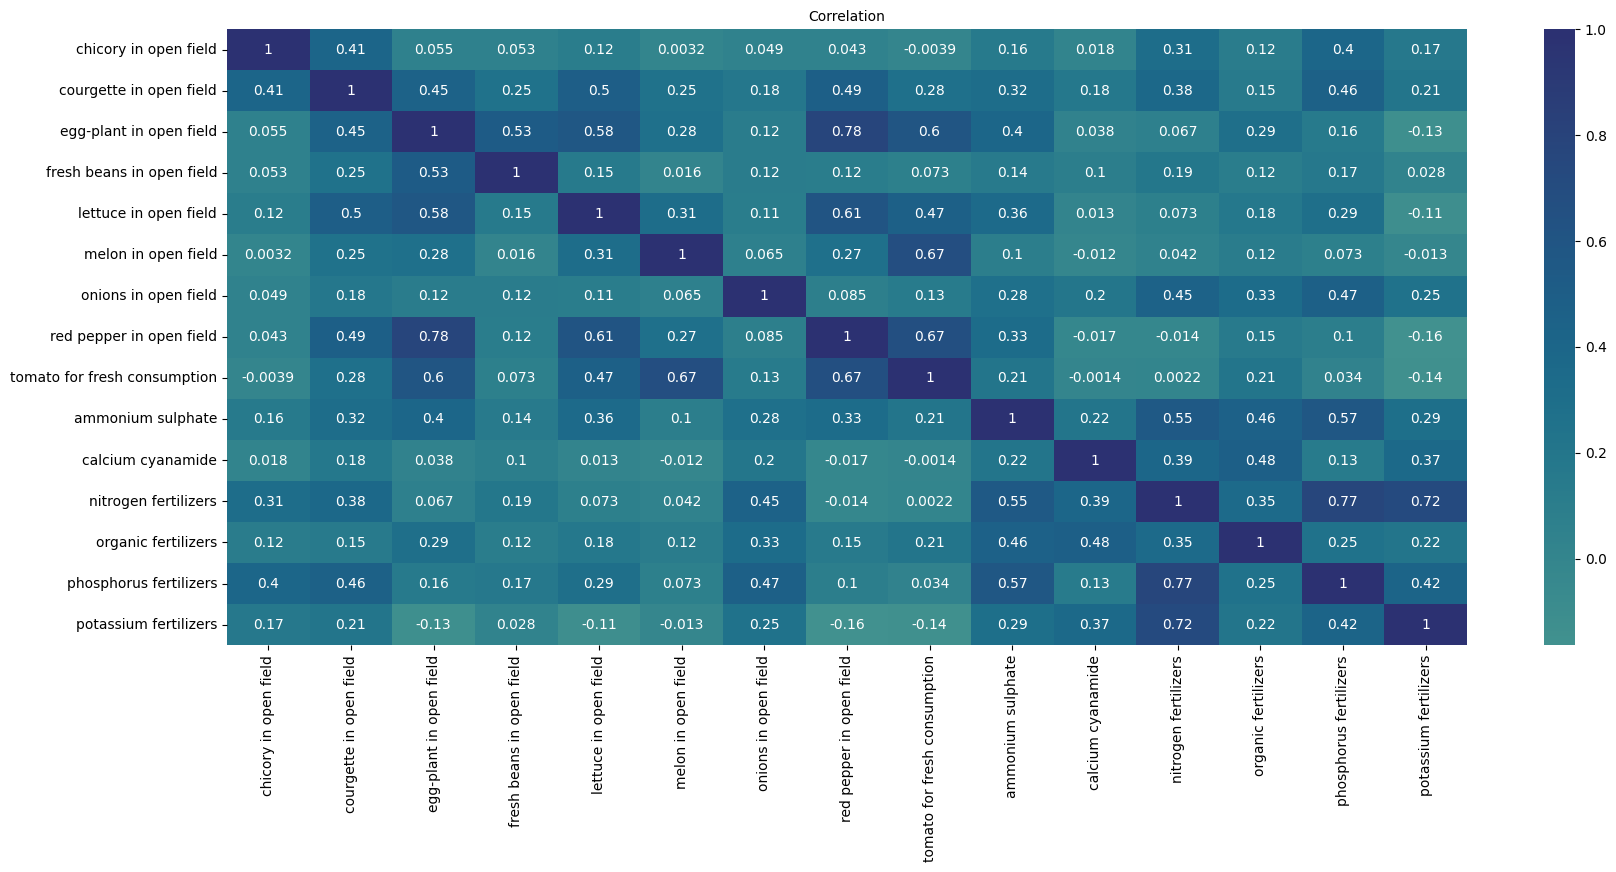

In [59]:
plt.figure(figsize=(20,8))
plt.title('Correlation', size=10)
sns.heatmap(cor_selected.corr(), cmap='crest', center=0, annot=True)

### Correlation analysis of fresh vegetables production in Italy - 2020:   

* Chicory has correlation with Courgette and phosphorus fertilizer.

* Cougette has high correlation with Lettuce potassium, Egg-plat, Red pepper, and phosphorus fertilizer.

* Egg-plat has high correlation with Red pepper, Cougette, Fresh beans and Lettuce. 

* Melon has high correlation with Tomatoes.

* Onions has correlation with phosphorus and nitrogen fertilizers.

### Correlation 2021


In [60]:

crop = it_crop_ferlizer2021.City.astype('category')
targets = dict(enumerate(crop.cat.categories))
it_crop_ferlizer2021['target']=crop.cat.codes

#y = it_crop_ferliser.Type_crop
cor_selected = it_crop_ferlizer2021[['City','chicory in open field','courgette in open field',
                                     'egg-plant in open field','fresh beans in open field',
                                     'lettuce in open field','melon in open field', 'onions in open field',
                                     'red pepper in open field','tomato for fresh consumption','ammonium sulphate',
                                 'calcium cyanamide','nitrogen fertilizers', 'organic fertilizers',
                                 'phosphorus fertilizers','potassium fertilizers']] 


<AxesSubplot: title={'center': 'Correlation'}>

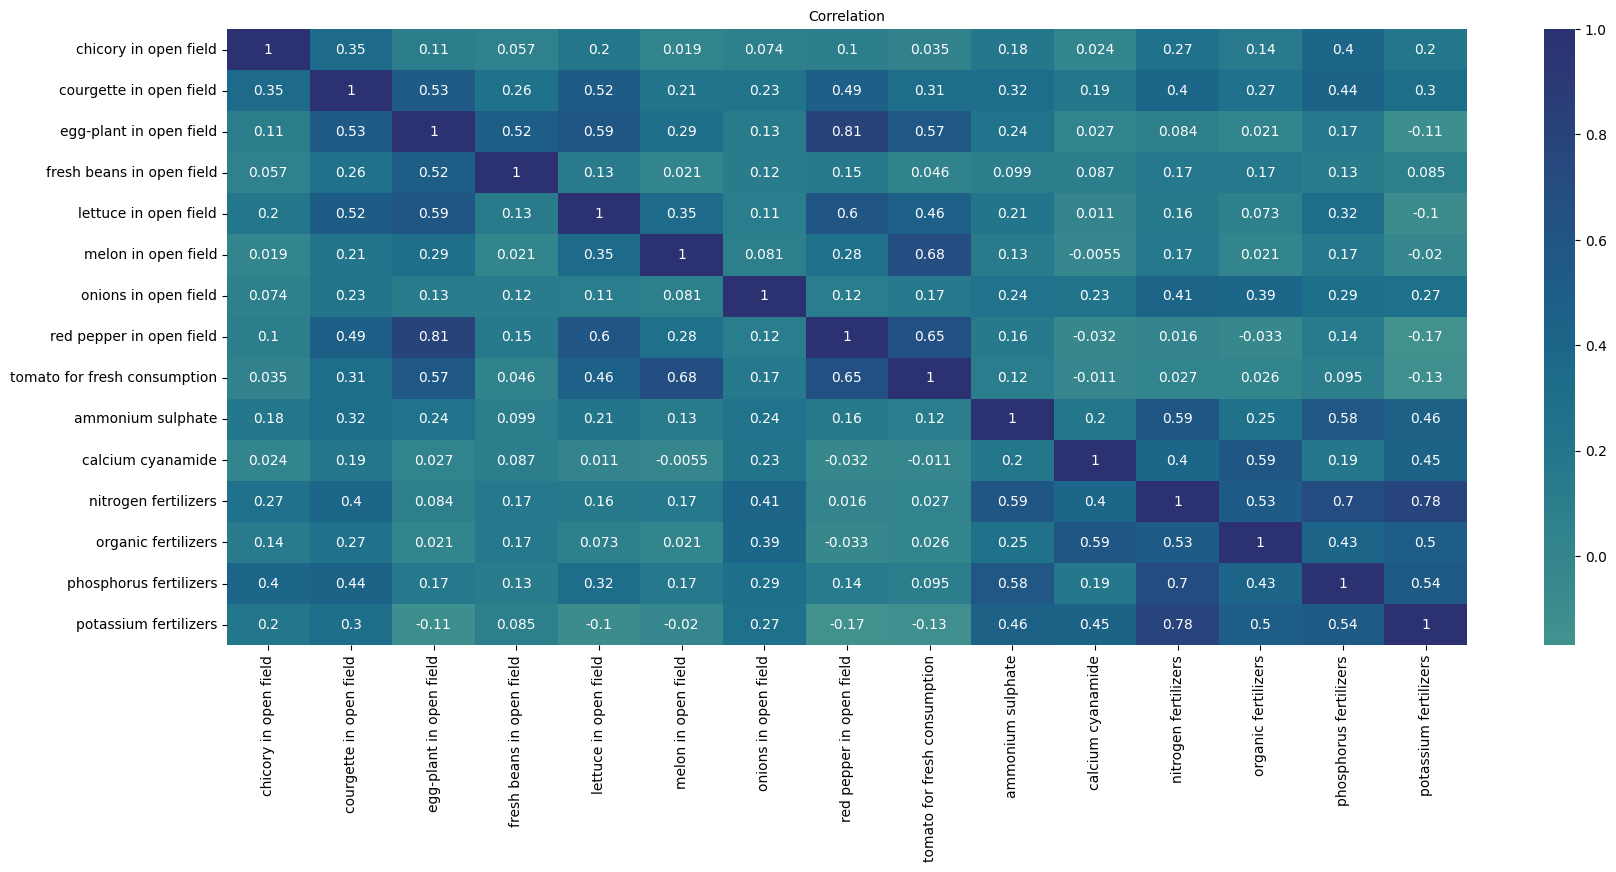

In [61]:
plt.figure(figsize=(20,8))
plt.title('Correlation', size=10)
sns.heatmap(cor_selected.corr(), cmap='crest', center=0, annot=True)

### Correlation analysis of fresh vegetables production and  fertilizers in Italy - 2021:   

* Chicory has correlation with phosphorus fertilizer, and hight correlation with Beans.

* Cougette has correlation with phosphorus and nitrogen fertilizers, and hight correlation with Egg-plant.

* Egg-plant has hight correlation with Red pepper , low correlation with fertilizers. 

* Lettuce has hight correlation with red pepper and Tomatoes, and low correlation with fertilizers.

* Melon has higher correlation with Tomatoes.

* Onions has correlation nitrogen fertilizers.

* There is also hight correlation between phosphorus and potassium with nitrogen fertilizer.


Modelling 

# References


http://dati.istat.it

https://maps.princeton.edu/catalog/stanford-mn871sp9778

https://www.crea.gov.it/documents/68457/0/ITACONTA+2020_ENG+DEF+xweb+%281%29.pdf/95c6b30a-1e18-8e94-d4ac-ce884aef76e8?t=1619527317576

https://seaborn.pydata.org/generated/seaborn.relplot.html